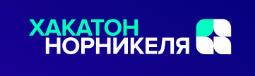

# Трек - Мультимодальные RAG модели 🔍️📊

### Часть 2 - Загрузка готовой векторной базы и получение инференсов

Данный ноутбук создан исключительно для вставки готовой векторной базы и генерации ответа через VLM с помощью составленного промпта с вопросом.

# 1. Установка и импорт нужных инструментов

Установим требуемые нам библиотеки: 
* `byaldi` - высокоуровневый [фреймворк](https://github.com/AnswerDotAI/byaldi) непосредственно для работы с моделями ColPali
* `pdf2image` - для перевода `.pdf`-файлов в изображения
* `poppler-utils` - для работы `pdf2image`
* `Spire.Doc` - для перевода `.docx`-файлов в формат `.pdf`
* `qwen-vl-utils` - для работы Qwen-VL-моделей

**Важно!**

В данном ноутбуке загрузка модели ColPali через загрузку готовой векторной базы производилась на один GPU видеокарты: `cuda:0`, а загрузка VLM-модели на другой GPU: `cuda:1`. Просьба иметь это ввиду.

Для работы обязательно потребуются данные (сами документы), предоставленные организаторами хакатона (архив `RAG.zip` весом в 450,4 МБ), как в первой части ноутбука, а так же готовая векторная база, которая была получена в первой части (либо же их можно скачать отдельно - [ссылка на Google Drive](https://drive.google.com/file/d/15WW-PUqtn7RVzGB1eaged3oRX9eNijoy/view?usp=drive_link)).

In [1]:
!pip install --upgrade byaldi -q
!sudo apt-get install -y poppler-utils -q
!pip install -q pdf2image flash-attn -q
!pip install Spire.Doc -q
!pip install qwen-vl-utils -q

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libpoppler118 poppler-data
Suggested packages:
  ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  libpoppler118 poppler-data poppler-utils
0 upgraded, 3 newly installed, 0 to remove and 72 not upgraded.
Need to get 3427 kB of archives.
After this operation, 17.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 poppler-data all 0.4.11-1 [2171 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpoppler118 amd64 22.02.0-2ubuntu0.5 [1071 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 3427 kB in 1s (2880 kB/s)
Selecting previously unselected package poppler-data.

Определим папку, где у нас лежат первоначальные данные `input_folder`, а так же папку, куда мы переведём файлы непосредственно для работы с RAG-системой `working_folder`. Мы работаем в ноутбуке Kaggle, потому обозначим папку, где у нас лежит готовая RAG-база `rag_input_dir`, и папку, куда мы положим её для поиска релевантных документов `rag_target_dir`.

При работе на локальной машине, скорее всего, ничего перемещать не требуется.

In [2]:
from byaldi import RAGMultiModalModel
import torch
from pdf2image import convert_from_path
import os
import shutil
from spire.doc import *
from spire.doc.common import *
import gzip
import json
from PIL import Image, ImageFilter
from typing import List, Dict


input_folder = '/kaggle/input/nornikel-2024/'
working_folder = '/kaggle/working/nornikel-2024/'
rag_input_dir = '/kaggle/input/nornikel-2024-rag'
rag_target_dir = '/kaggle/working/nornikel-2024-rag'

if not os.path.exists(working_folder):
    os.makedirs(working_folder)

# 2. Подготовка данных

**Крайне важно!**

Код ниже перекидывает векторную базу из `rag_input_dir` в `rag_target_dir`.

Вся работа велась в Kaggle, а при подгрузке данных он автоматически распаковывает все архивы (`.zip`, `.tar.gz`, `.gz`), для загрузки конфигурационных файлов byaldi требует наличия именно заархифированных конфиг-файлов (то есть не `.json`, а `.json.gz`), поэтому пришлось их все заархивировать в прежний формат.

Если не требуется перемещение векторной базы в рабочую среду из `input` (как в случае с Kaggle), то строку можно закомментить.

In [3]:
def process_files(
    source: str, 
    target: str
    ) -> None:
    """
    Перемещает файлы из исходной директории в целевую, с дополнительной обработкой:
    - Для файлов формата `.json` создаётся сжатая версия `.json.gz`.
    - Все остальные файлы копируются без изменений.
    Конфигурационные файлы `.json` также могут быть зашифрованы или обработаны в дальнейшем.

    Аргументы:
        source (str): Путь к исходной директории, содержащей файлы.
        target (str): Путь к целевой директории, куда будут перемещены файлы.

    Возвращает:
        None: Функция не возвращает значения, так как результат сохраняется в указанной целевой директории.
    
    Примечания:
        - Для файлов с расширением `.json` создаётся сжатая версия в формате `.json.gz`.
        - Файлы с другими расширениями просто копируются в целевую директорию.
    """
    os.makedirs(target, exist_ok=True)

    for root, dirs, files in os.walk(source):
        rel_path = os.path.relpath(root, source)
        target_root = os.path.join(target, rel_path)

        os.makedirs(target_root, exist_ok=True)

        for filename in files:
            source_path = os.path.join(root, filename)
            target_path = os.path.join(target_root, filename)

            if filename.endswith('.json'):
                target_path = target_path.replace('.json', '.json.gz')
                with open(source_path, 'rb') as f_in:
                    with gzip.open(target_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
            else:
                shutil.copy2(source_path, target_path)

process_files(rag_input_dir, rag_target_dir)

Сформируем словарь со всеми нашими документами, чтобы в дальнейшем было проще с ними работать.

In [4]:
file_path = '/kaggle/working/nornikel-2024-rag/nornikel_index/doc_ids_to_file_names.json.gz'
docs_names = dict()

with gzip.open(file_path, 'rt', encoding='utf-8') as f:
    docs_names = json.load(f)
    docs_names = {int(key): value for key, value in docs_names.items()}

In [5]:
def convert_doc_to_pdf(
    doc_path: str, 
    pdf_path: str
    ) -> None:
    """
    Конвертирует Microsoft Word файл (.doc, .docx) в формат PDF.

    Аргументы:
        doc_path (str): Путь к исходному документу Word (например, 'example.docx').
        pdf_path (str): Путь для сохранения результата в формате PDF (например, 'output.pdf').

    Возвращает:
        None: Функция не возвращает значения, так как результат сохраняется непосредственно в файл.
    """
    document = Document()
    document.LoadFromFile(doc_path)
    document.SaveToFile(pdf_path, FileFormat.PDF)
    document.Close()

Переведём все наши `.pdf`-файлы в рабочий каталог, а файлы `.docx` переведём в требуемый для ColPali формат `.pdf`.

In [6]:
all_documents = os.listdir(input_folder)

for file in all_documents:
    file_path = os.path.join(input_folder, file)
    if file_path.endswith('.docx') or file_path.endswith('.doc'):
        file_path = convert_doc_to_pdf(file_path, working_folder + file[:-4] + 'pdf')
        print(f"Копирован и переведён в формат .pdf файл: {file[:-4] + 'pdf'}")
    else:
        shutil.copy(file_path, working_folder)
        print(f"Копирован файл: {file}")

Копирован файл: Alrosa_Обзор_рынка_инвестиционных_бриллиантов_октябрь_2024.pdf
Копирован файл: Росконгресс_Рынок_промышленных_роботов_в_мире_и_России_2024_16_стр.pdf
Копирован файл: nn_climate_change_report_rus.pdf
Копирован файл: Норникель про корп культуру.pdf
Копирован файл: ММК 2024.pdf
Копирован файл: Доклад, уголь часть 1.pdf
Копирован файл: Godovoi_-otchet-PAO-GMK-Norilskii_-nikel-za-2023-god.pdf
Копирован файл: sr_ru_annual_report_pages_nornik_2022.pdf
Копирован файл: Норникель_Внутрення_цена_на_углерод.pdf
Копирован файл: 2_5282802846297776741.pdf
Копирован и переведён в формат .pdf файл: СП_496_1325800_2020_Основания_и_фундаменты_зданий_и_сооружений.pdf
Копирован файл: digital_production_5.pdf
Копирован файл: NN_AR_2021_Book_RUS_26.09.22.pdf
Копирован файл: McKinsey_Next Big Arenas_2024 (213 pgs).pdf
Копирован файл: KPMG_Global Metals and Mining_2024 (48 pgs).pdf
Копирован файл: NN_CSO2021_RUS_03.03.2023.pdf
Копирован файл: 2022_Annual_Report_of_PJSC_MMC_Norilsk_Nickel_rus.

# 3. Загрузка готовой векторной базы

Загрузим нашу готовую базу по индексу, который мы задали в первой части ноутбука, переведём её в работу на `cuda:0`.

In [7]:
RAG = RAGMultiModalModel.from_index(
    index_path='nornikel_index/',
    index_root='/kaggle/working/nornikel-2024-rag',
    device='cuda:0'
)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.indexed_embeddings.extend(torch.load(file))


По текстовому запросу определим k релевантных документов.

In [8]:
text_query = "Какой актив формирует наибольшую долю FCF? Какой актив на 2 месте?"
results = RAG.search(text_query, k=3)

torch.cuda.empty_cache()

In [9]:
for result in results:
    doc_id = result['doc_id']
    page_num = result['page_num']
    score = result['score']

    print(f"Документ ID: {doc_id}, Страница: {page_num}, Релевантность: {score}")

Документ ID: 8, Страница: 4, Релевантность: 18.75
Документ ID: 7, Страница: 3, Релевантность: 18.375
Документ ID: 7, Страница: 1, Релевантность: 18.25


# 4. Загрузка VLM и выполнение инференсов

Так как ColPali не считывает напрямую текст с документов и изображений, нам потребуется языковая LLM или VLM. Для ответа по релевантным страницам документов и текстовому запросу используем VLM-модель `Qwen-2-VL-2B`, а именно дообученную на русских текстах версию от Vikhrmodels: `Vikhr-2-VL-2b-Instruct-experimental`.

In [10]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

model_id = "Vikhrmodels/Vikhr-2-VL-2b-Instruct-experimental"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id, torch_dtype="auto", device_map="cuda:1"
)

processor = AutoProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Ниже мы берём релевантные страницы разных документов и переводим их в изображения. С целью оптимизации потребрения оперативной памяти снизим размер изображения примерно до 800 пикселей в длине.

In [11]:
def resize_text(
    img: Image, 
    max_size: int = 1000
    ) -> Image:
    """
    Изменяет размер изображения, пропорционально уменьшая его, чтобы максимальный 
    размер (ширина или высота) не превышал заданного значения. Также применяет фильтр 
    для увеличения резкости изображения.

    Аргументы:
        img (Image): Входное изображение, которое нужно изменить.
        max_size (int, optional): Максимальный размер для ширины или высоты изображения 
                                  (по умолчанию 1000 пикселей). Изображение будет масштабировано, 
                                  чтобы его наибольший размер (ширина или высота) стал равен или меньше 
                                  этого значения, сохраняя пропорции.

    Возвращает:
        Image: Изменённое изображение с применённым фильтром четкости.
    """
    width, height = img.size
    if max(width, height) > max_size:
        if width > height:
            new_width = max_size
            new_height = int(height * (max_size / width))
        else:
            new_height = max_size
            new_width = int(width * (max_size / height))
            
        img = img.resize((new_width, new_height), Image.LANCZOS)
        img = img.filter(ImageFilter.SHARPEN)

    return img

In [12]:
def get_relevant_images_ready(
    docs_names: Dict[str, int], 
    results: List[Dict[str, int]]
    ) -> List[str]:
    """
    Извлекает и подготавливает изображения из документов на основе информации 
    о страницах из списка результатов поиска. Функция создаёт изображения 
    для каждой страницы и сохраняет их на диск.

    Аргументы:
        docs_names (Dict[str, int]): Словарь, где ключ — это имя документа (строка), 
                                      а значение — это путь к PDF-файлу (целое число).
        results (List[Dict[str, int]]): Список результатов поиска, где каждый элемент 
                                        представляет собой словарь с ключами 'doc_id' 
                                        (идентификатор документа) и 'page_num' 
                                        (номер страницы).

    Возвращает:
        List[str]: Список путей к подготовленным изображениям, готовым для использования в контексте.
    """
    images = [docs_names[results[i]['doc_id']] for i in range(len(results))]
    image_path = '/kaggle/working/nornikel-2024/relevant_images/'
    
    os.makedirs(image_path, exist_ok=True)
    pages_to_convert = dict()
    
    for doc, page in zip(images, [doc['page_num'] for doc in results]):
        pages_to_convert.setdefault(doc, []).append(page)
    
    ready_images_for_context = []
    
    for i, (pdf, pages) in enumerate(pages_to_convert.items()):
        for j, page in enumerate(pages):
            output_img_name = f'{image_path}/image_{i + 1}_{j + 1}.jpg'
            
            image = convert_from_path(pdf, first_page=page, last_page=page)
            image = resize_text(*image)
            image.save(output_img_name, 'JPEG')

            ready_images_for_context.append(output_img_name)
    

    return ready_images_for_context

In [13]:
relevant_images = get_relevant_images_ready(docs_names, results)

Формируем контент для контектного окна, куда мы передаём наш текстовый запрос и пути по готовых изображений.

In [14]:
content = [
    *[{"type": "image", "image": image} for image in relevant_images],
    {"type": "text", "text": text_query}
]

role_text = '''Ты бизнес-ассистент в компании Норникель. 
По существу и профессионально ответь на вопрос, опираясь на контекст изображений.'''

In [15]:
messages = [
    {"role": "system", "content": [{"type": "text", "text": role_text}]},
    {
        "role": "user",
        "content": content,
    }
]

display(messages)

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'Ты бизнес-ассистент в компании Норникель. \nПо существу и профессионально ответь на вопрос, опираясь на контекст изображений.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': '/kaggle/working/nornikel-2024/relevant_images//image_1_1.jpg'},
   {'type': 'image',
    'image': '/kaggle/working/nornikel-2024/relevant_images//image_2_1.jpg'},
   {'type': 'image',
    'image': '/kaggle/working/nornikel-2024/relevant_images//image_2_2.jpg'},
   {'type': 'text',
    'text': 'Какой актив формирует наибольшую долю FCF? Какой актив на 2 месте?'}]}]

In [16]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda:1")

После передачи текстового запроса в модель получаем готовый сгенерированный моделью ответ.

In [17]:
generated_ids = model.generate(
    **inputs,
    max_length=2048,
    temperature=0.3,
    top_k=100,
    top_p=0.95,
    max_new_tokens=1024
)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

torch.cuda.empty_cache()

print(output_text[0])

Both `max_new_tokens` (=1024) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Наибольший уровень прибыли в компании Норникель в 2018 году, что составляет 11,8% от чистых активов.


# 5. Тест ответов на вопросы хакатона

Загрузим имеющиеся тренировочные вопросы хакатона и покажем, как отвечает в нашем случае модель.

In [18]:
questions = '''1. Долевое участие металлов в EBITDA компании? То есть какой % EBITDA и EBITDA margin принесли продажи Ni, Cu и т д
2. Как долевое участие металлов в EBITDA компании? менялась от года к году (наверн нужно приложить отчеты хотя бы за 2-3 года)?
3. Топ 5 факторов снижения EBITDA г/г? Также и EBITDA margin
4. Какой актив формирует наибольшую долю FCF? Какой актив на 2 месте?
5. Какие активы являются убыточными? Можно ли их исключить из производственной цепочки без последствий для общего цикла производства металлов?
6. Какой прогноз по содержанию металлов руд НН на следующие 5 лет? 
7. Какую долю рынка занимает НН в производстве металлов? Как изменялась доля НН г/г? Какой прогноз на 5 лет?
8. Как изменялся прогноз по предложению и спросу на Ni, Cu, Au в отчетах за разные года, например какой был прогноз в отчете за 2020 год на 2021/22/23? Какое было фактическое предложение и спрос в годовых отчетах 2021/22/23? Исходя из этого сделай вывод о целесообразности доверия таким прогнозам в целом'''

In [19]:
questions = [q[3:] for q in questions.split('\n')]
display(questions)

['Долевое участие металлов в EBITDA компании? То есть какой % EBITDA и EBITDA margin принесли продажи Ni, Cu и т д',
 'Как долевое участие металлов в EBITDA компании? менялась от года к году (наверн нужно приложить отчеты хотя бы за 2-3 года)?',
 'Топ 5 факторов снижения EBITDA г/г? Также и EBITDA margin',
 'Какой актив формирует наибольшую долю FCF? Какой актив на 2 месте?',
 'Какие активы являются убыточными? Можно ли их исключить из производственной цепочки без последствий для общего цикла производства металлов?',
 'Какой прогноз по содержанию металлов руд НН на следующие 5 лет? ',
 'Какую долю рынка занимает НН в производстве металлов? Как изменялась доля НН г/г? Какой прогноз на 5 лет?',
 'Как изменялся прогноз по предложению и спросу на Ni, Cu, Au в отчетах за разные года, например какой был прогноз в отчете за 2020 год на 2021/22/23? Какое было фактическое предложение и спрос в годовых отчетах 2021/22/23? Исходя из этого сделай вывод о целесообразности доверия таким прогнозам в 

Далее составим функцию-пайплайн, которая будет содержать главные моменты: через получение запроса поиск релевантных страниц в документах, перевод этих страниц в изображения с уменьшением размерности, а так же составлением промпта с передачей его в VLM для генерации ответа на вопрос пользователя в текстовом запросе.

In [ ]:
def get_answer_on_query(
    text_query: str,
    role_text: str = role_text,
    k: int = 3, 
    model: Qwen2VLForConditionalGeneration = model, 
    processor: AutoProcessor = processor,
    temperature: float = 0.3
    ) -> str:
    """
    Получает ответ на заданный текстовый запрос, используя систему на основе RAG.
    Функция обрабатывает запрос, извлекает релевантные документы и генерирует ответ 
    с помощью предобученной модели, учитывая как текст, так и изображения.

    Аргументы:
        text_query (str): Текстовый запрос, на который нужно получить ответ.
        k (int, optional): Количество релевантных документов (изображений/текстов), которые нужно извлечь (по умолчанию 3).
        model (Qwen2VLForConditionalGeneration, optional): Модель, используемая для генерации текста (по умолчанию — заранее определённая модель).
        processor (AutoProcessor, optional): Процессор, используемый для подготовки входных данных для модели (по умолчанию — заранее определённый процессор).
        role_text (str, optional): Текст, который задаёт роль или контекст для ассистента (по умолчанию — заранее определённый текст).
        temperatute(float, optional): Уровень креативности модели (по умолчанию - 0.3).

    Возвращает:
        str: Сгенерированный ответ на текстовый запрос.
    """
    # 1. Поиск релевантных страниц в векторной базе
    results = RAG.search(text_query, k=k)

    # 2. Перевод релевантных страниц в изображения
    relevant_images = get_relevant_images_ready(docs_names, results)

    # 3. Формирование промпта
    content = [
    *[{"type": "image", "image": image} for image in relevant_images],
    {"type": "text", "text": text_query}
    ]

    system_prompt = '''Ты бизнес-ассистент в компании Норникель. По существу и профессионально ответь на вопрос, опираясь на контекст изображений.
    Не пиши, что изображено на картинках.Твоя задача — находить наиболее релевантные результаты для заданного вопроса. Пожалуйста, следуй этим инструкциям:
    1. **Ответ на вопрос**: Если информация, необходимая для ответа на вопрос, содержится в тексте, предоставь детальный и точный ответ, основываясь только на этой информации.
    2. **Отсутствие информации**: Если в тексте нет информации, относящейся к вопросу, ответь: "Я не нашёл информацию в тексте."
    3. **Неуверенность в ответе**: Если ты не уверен в правильности ответа или считаешь, что информация может быть недостаточной, ответь: "Я не уверен в ответе" и предоставьте свой ответ.'''

    few_shot_prompt = '''
    Пример 1:
    Вопрос: Каковы основные преимущества продукта X?
    Ответ: Основные преимущества продукта X включают высокую эффективность, доступность и простоту использования.
    Пример 2:
    Вопрос: Какие шаги необходимо предпринять для запуска проекта Y?
    Ответ: Для запуска проекта Y необходимо выполнить следующие шаги: 1) провести исследование рынка; 2) разработать бизнес-план; 3) собрать команду; 4) запустить маркетинговую кампанию.
    Пример 3:
    Вопрос: Какова история компании Z?
    Ответ: Я не нашёл информацию в тексте.
    Пример 4:
    Вопрос: Какие риски связаны с продуктом A?
    Ответ: Я не уверен в ответе: возможно, стоит уточнить детали о рисках, связанных с продуктом A.
    '''

    # Формирование сообщений для модели
    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_prompt}]},  # Системный промпт
        {"role": "system", "content": [{"type": "text", "text": few_shot_prompt}]},  # Few-shot примеры
        {"role": "user", "content": content}
    ]
    

    # 4. Токенизация промпта
    text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda:1")

    # 5. Передача затокенизированного промпта в VLM
    generated_ids = model.generate(
    **inputs,
    max_length=2048,
    temperature=temperature,
    top_k=100,
    top_p=0.95,
    max_new_tokens=1024
    )
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    # 6. Вывод на экран вопроса пользователя, сгенерированного ответа и релевантные изображения
    print('-' * 50)
    print('user_question:', text_query)
    print()
    print('VLM_answer:', output_text[0])

    img1 = Image.open(relevant_images[0])
    img2 = Image.open(relevant_images[1])
    display(img1, img2)

    # 7. Чистка старых обработанных изображений и кэша GPU
    shutil.rmtree("/kaggle/working/nornikel-2024/relevant_images")
    os.makedirs("/kaggle/working/nornikel-2024/relevant_images")
    torch.cuda.empty_cache()

Запустим ниже процесс генерации ответов, введём в модель значения некоторых параметров (роль, текстовый запрос, число k релевантных документов для поиска и процент креативности ответа). 

Демонстрация ответов на первые 5 тренировочных вопросов.

Question 1


Both `max_new_tokens` (=1024) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


--------------------------------------------------
user_question: Долевое участие металлов в EBITDA компании? То есть какой % EBITDA и EBITDA margin принесли продажи Ni, Cu и т д

VLM_answer: Да, Ты бизнес-ассистент является сотрудником компании Норникель.


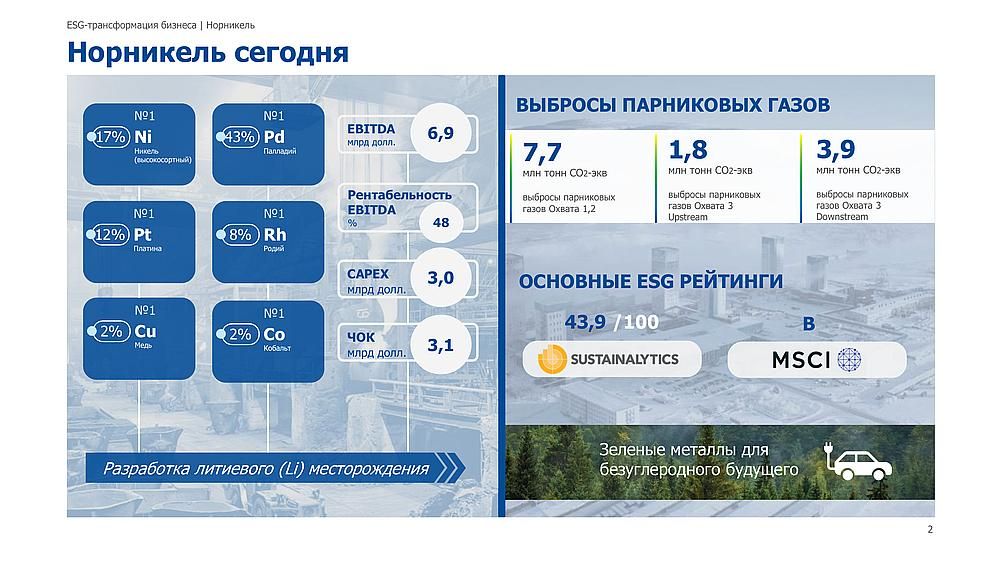

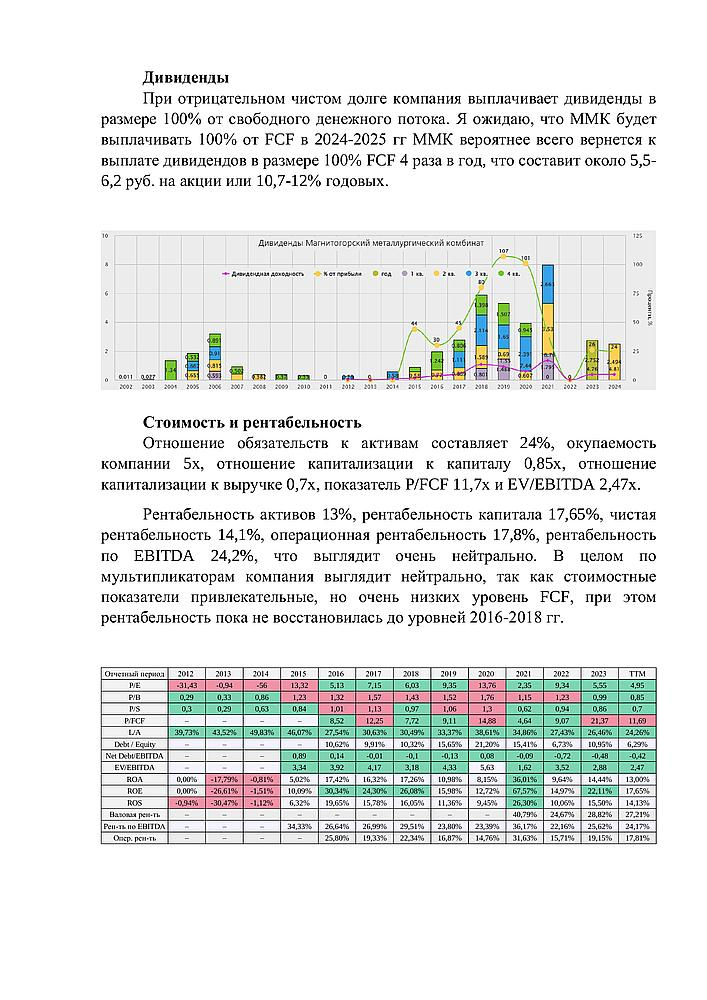

Question 2


Both `max_new_tokens` (=1024) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


--------------------------------------------------
user_question: Как долевое участие металлов в EBITDA компании? менялась от года к году (наверн нужно приложить отчеты хотя бы за 2-3 года)?

VLM_answer: Да, на финансовом отчете компании Норникель показаны ключевые показатели, включая дивиденды, уровень общей стоимости, показатели ROA, ROE и ROCE. Также в разделе "Дивиденды" опубликованы ключевые показатели, такие как отношение к активам, уровень общей стоимости, показатель ROA, ROE и ROE.


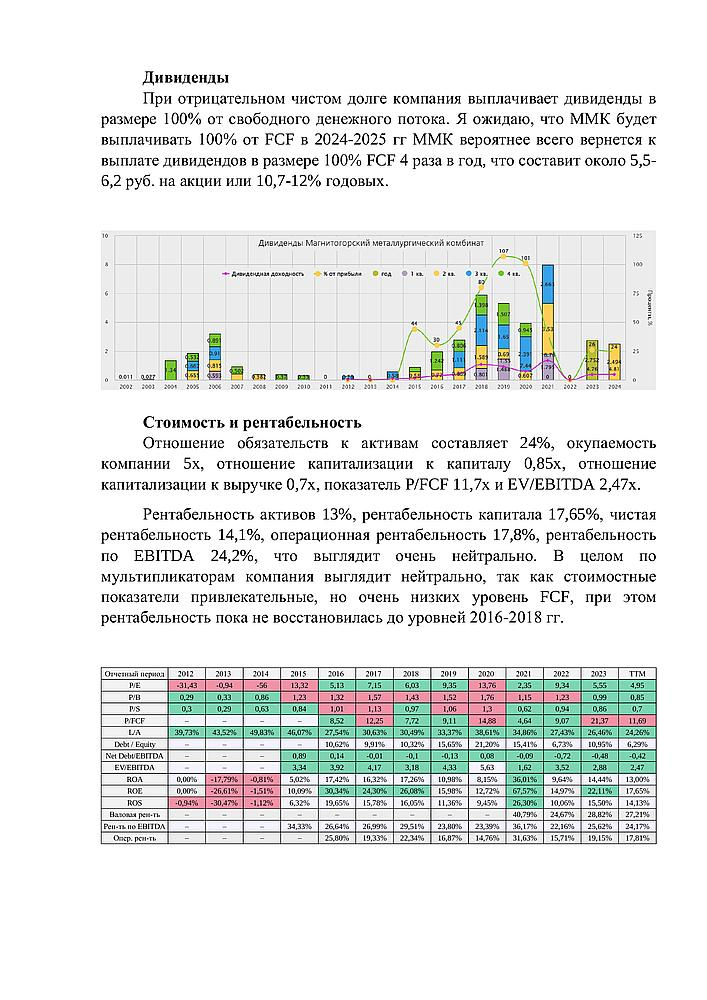

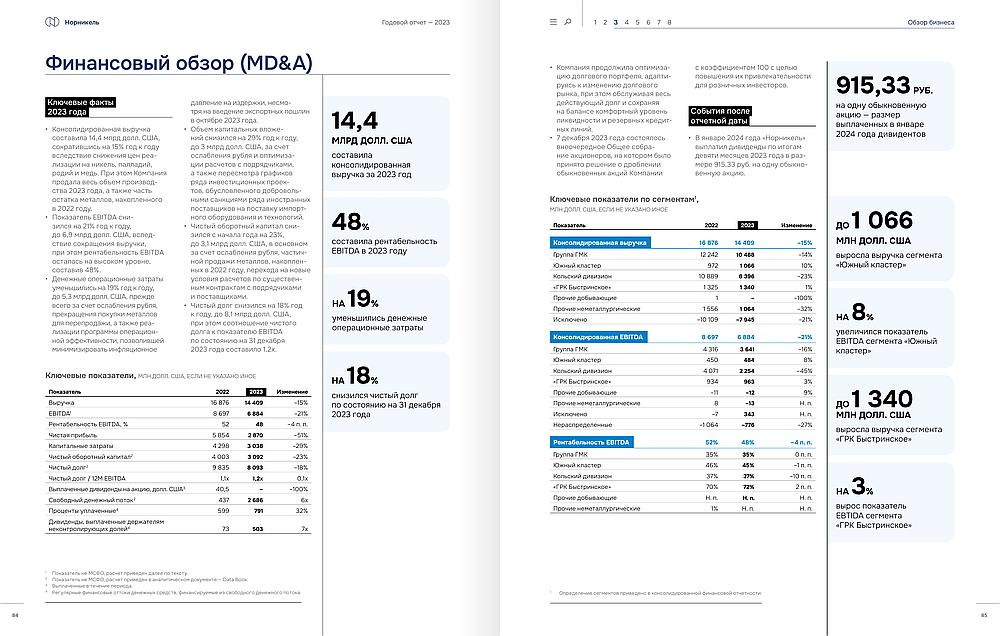

Question 3


Both `max_new_tokens` (=1024) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


--------------------------------------------------
user_question: Топ 5 факторов снижения EBITDA г/г? Также и EBITDA margin

VLM_answer: Да, на изображении показаны финансовые показатели компании Норкел, включая данные о прибыли, расходах и других финансовых показателях.


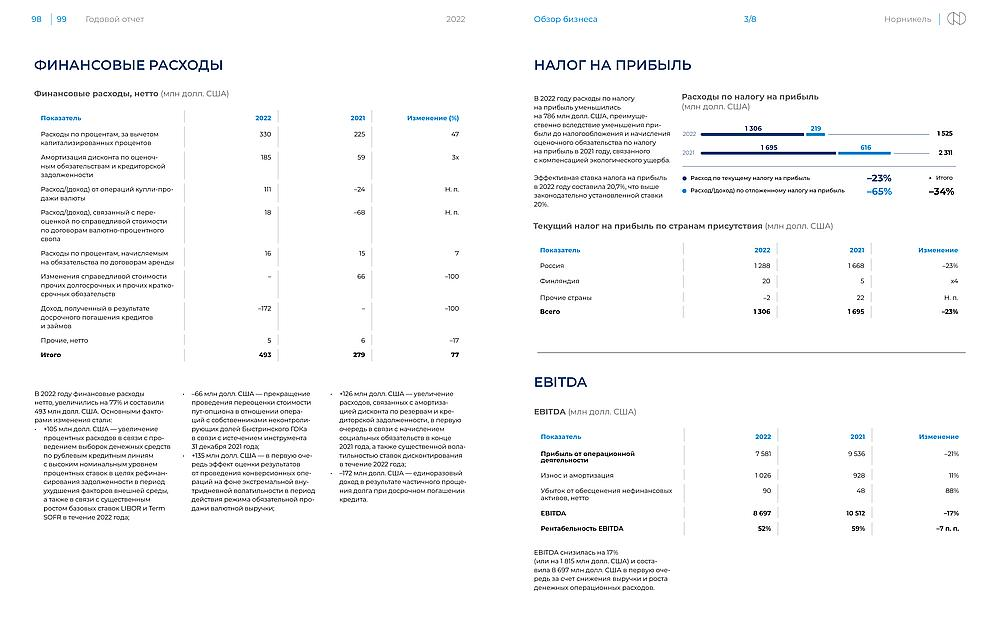

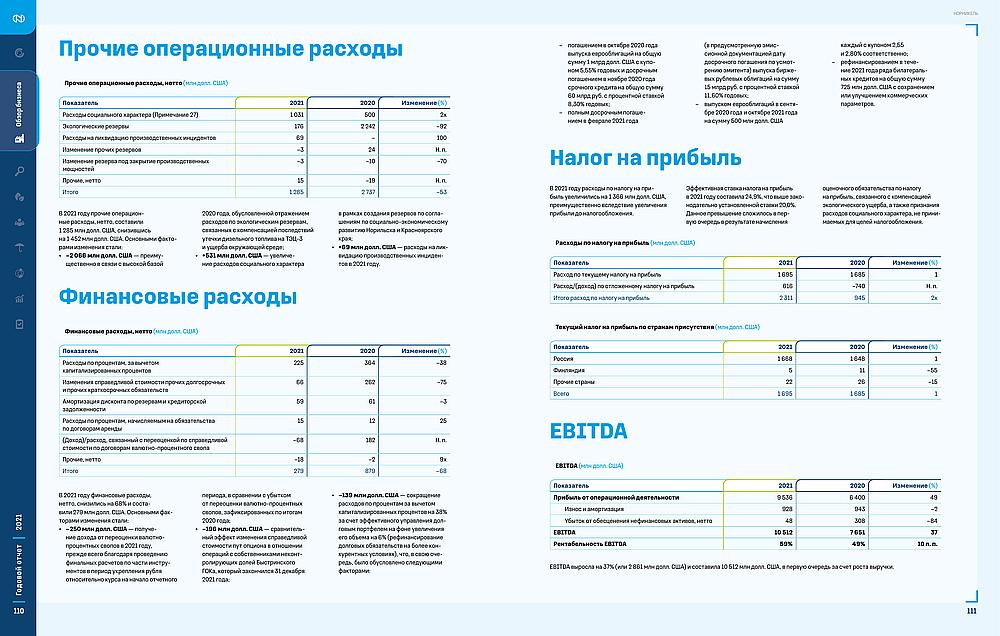

Question 4


Both `max_new_tokens` (=1024) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


--------------------------------------------------
user_question: Какой актив формирует наибольшую долю FCF? Какой актив на 2 месте?

VLM_answer: Дивидендная политика компании Норникель включает выплату дивидендов в размере 24% от ее прибыли, что делает ее лидером среди компаний с высоким уровнем дивидендной активности. Согласно данным, выручка компании выросла на 16,6% в 2024 году, что привело к 12,5% прироста к стоимости акций. В то же время, уровень активов снизился на 18,1% от 2019 года.


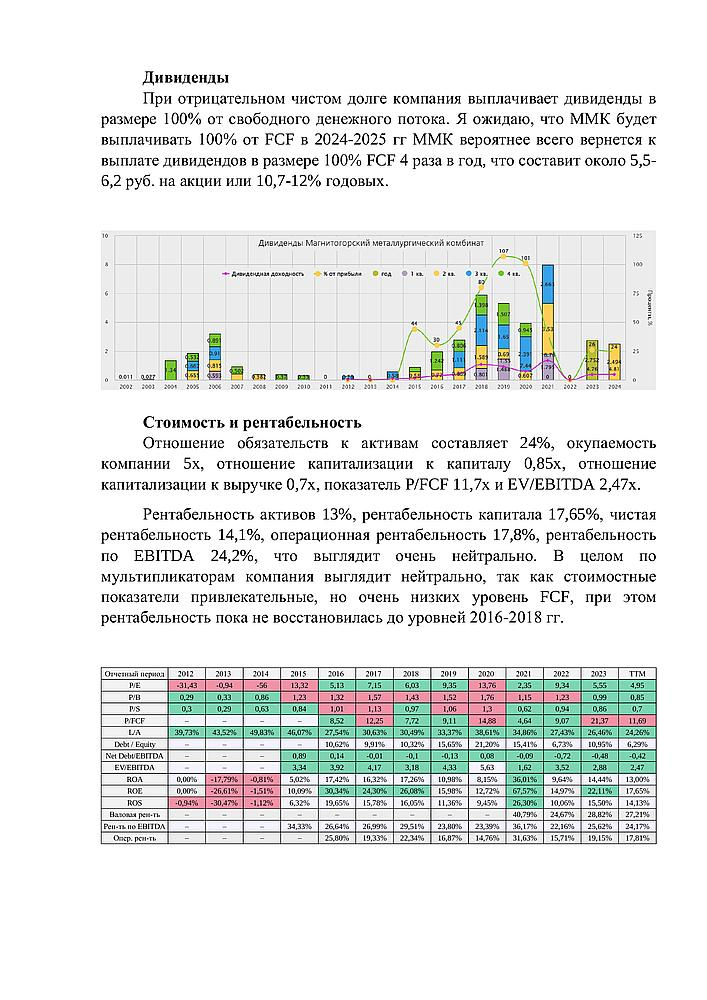

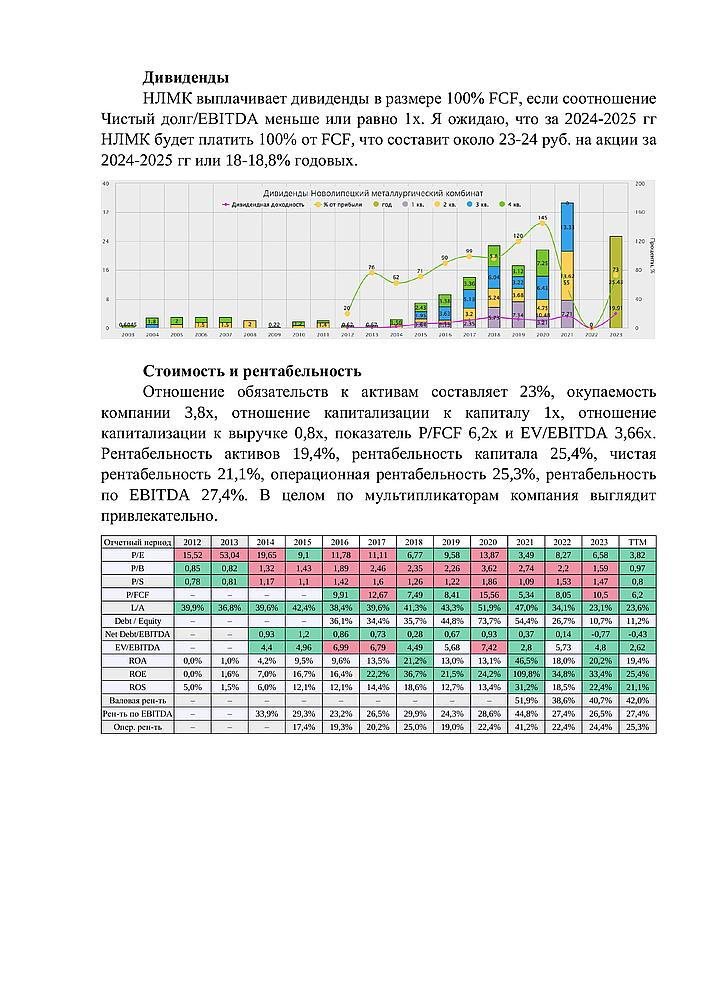

Question 5


Both `max_new_tokens` (=1024) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


--------------------------------------------------
user_question: Какие активы являются убыточными? Можно ли их исключить из производственной цепочки без последствий для общего цикла производства металлов?

VLM_answer: Да, на изображении изображена схема производства металлов, которая показывает связь между различными процессами и структуру производственной цепочки. Это позволяет читателю понять, как продукция металлов производится и как она связана с другими процессами.


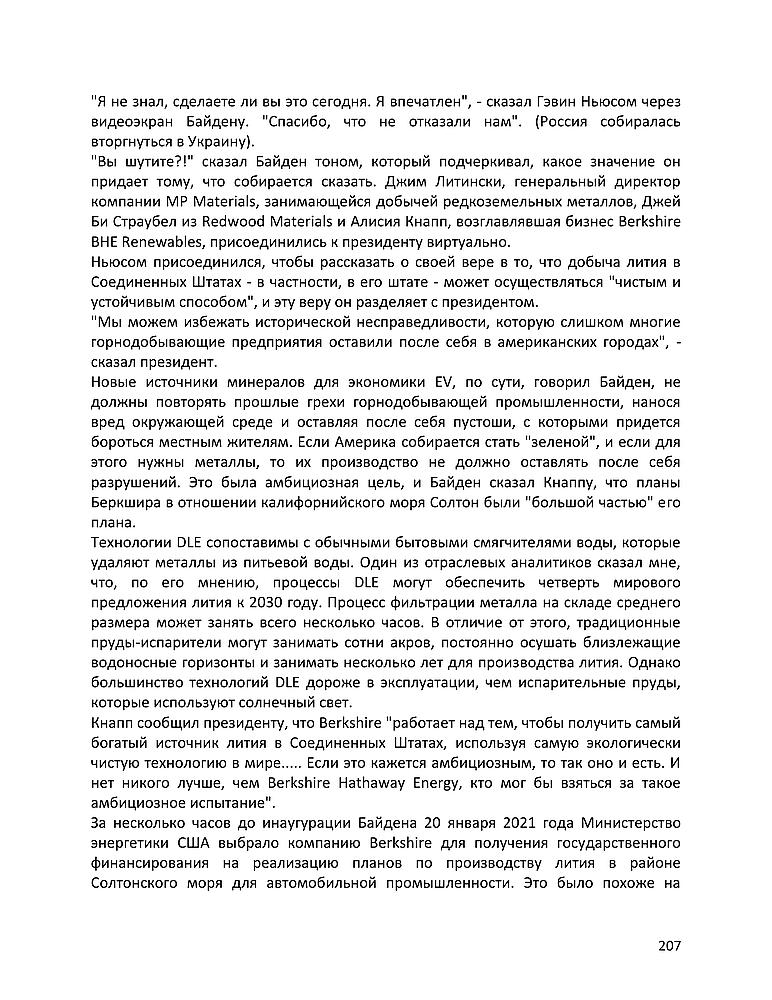

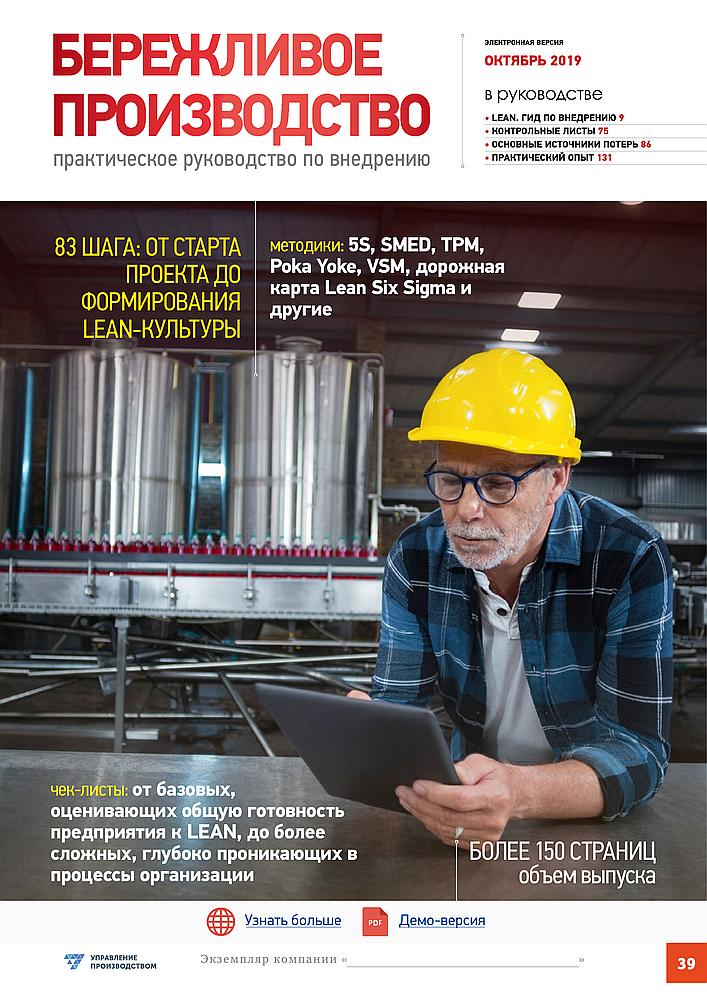

In [ ]:
# Требуется выставить необходимые настройки
# role_text - определение роли языковой модели
# k - сколько k релевантных страниц документов определять в векторной базе
# temperature - процент креативности модели (выше число - выше креативность ответов)

k = 3
temperature = 0.2

for i, q in enumerate(questions[:5], start=1):
    print(f'Question {i}')
    get_answer_on_query(q, k=k, temperature=temperature)

# Заключение 🏁

Выполнение второй части завершено. Данная часть была сделана исключительно, чтобы показать выдачу инференсов в рамках мультимодальной RAG-системы при наличии готовой векторной базы (она была создана в рамках первой части).

Доступна так же полная версия, которая показывает в целом весь пайплайн решения данной проблемы: индексация векторной базы, а так же выполнение инференсов с помощью текстового запроса.

Использование памяти:

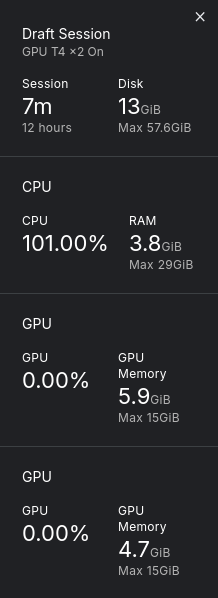